## COVID-19 X-ray Classification

### <ins>1. Objective</ins>
#### Coronavirus disease (COVID-19) is an respiratory infectious disease caused by the SARS-CoV-2 virus.
#### Chest x-rays can be used in diagnosis and follow up in patients with COVID-19 pneumonia. Given the strain on the medical staff, automatic diagnosis of COVID-19 from chest x-ray can free up personnel needs.

In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping

### <ins>2. Data</ins>
#### Data is from https://www.kaggle.com/datasets/masumrefat/chest-xray-images-pneumonia-and-covid19

#### Data consists of axial, coronal and saggital views of the chest for the following 3 classifications as determined by radiologists
1. COVID-19 positive
<img src="Chest_xray_image_dataset_covid_19_and_others/train/Covid_19/1-s2.0-S1684118220300608-main.pdf-001.jpg" alt="covid" style="width: 50px;"/>

2. Normal
<img src="Chest_xray_image_dataset_covid_19_and_others/train/NORMAL/NORMAL2-IM-0256-0001.jpeg" alt="covid" width="100"/>

3. Pneumonia (COVID-19 negative)
<img src="Chest_xray_image_dataset_covid_19_and_others/train/PNEUMONIA/person343_virus_704.jpeg" alt="covid" width="100"/>

#### Approach
Use Deep Learning to classify chest x-rays into Covid-19, normal and pneumonia (Covid-19 negative). 3 models used includes,
1. VGG16 type model
2. Transfer learning with ResNet
3. Hyperparameter tuned transfer learning with ResNet.

### <ins>3. Data Exploration</ins>
Find the largest and smallest image size from the training set. This will be used to determine an appropriate image size used for training and prediction. Too big and training will take a long time requiring lots of memory. Too small and critical information will be lost in resizing.

In [24]:
# collect images from each path in training set
train_data_dir = "./Chest_xray_image_dataset_covid_19_and_others/train"

train_covid_images = [os.path.join(train_data_dir, 'Covid_19', image) for image in os.listdir(os.path.join(train_data_dir, 'Covid_19'))]
train_normal_images = [os.path.join(train_data_dir, 'NORMAL', image) for image in os.listdir(os.path.join(train_data_dir, 'NORMAL'))]
train_pneumonia_images = [os.path.join(train_data_dir, 'PNEUMONIA', image) for image in os.listdir(os.path.join(train_data_dir, 'PNEUMONIA'))]

print("Number of Covid_19 images in training dataset, ", len(train_covid_images))
print("Number of Normal images in training dataset, ", len(train_normal_images))
print("Number of Pneumonia images in training dataset, ", len(train_pneumonia_images))

Number of Covid_19 images in training dataset,  210
Number of Normal images in training dataset,  1260
Number of Pneumonia images in training dataset,  3420


In [25]:
# get list of image sizes
image_size_list = list()
for image_path in train_covid_images+train_normal_images+train_pneumonia_images:
    image_size_list.append(Image.open(image_path).size)

In [26]:
# find largest and smallest image size in training set
largest_image_size = list(map(max, zip(*image_size_list)))
smallest_image_size = list(map(min, zip(*image_size_list)))
  
print ("Largest image size in training set, ", largest_image_size)
print ("Smallest image size in training set. ", smallest_image_size)

Largest image size in training set,  [4298, 4300]
Smallest image size in training set.  [255, 127]


In [27]:
# assign image size used for training prediction.
image_width = 224
image_height = 224

In [28]:
# collect images from each path in testing set
test_data_dir = "./Chest_xray_image_dataset_covid_19_and_others/test"

test_covid_images = [os.path.join(test_data_dir, 'Covid_19', image) for image in os.listdir(os.path.join(test_data_dir, 'Covid_19'))]
test_normal_images = [os.path.join(test_data_dir, 'NORMAL', image) for image in os.listdir(os.path.join(test_data_dir, 'NORMAL'))]
test_pneumonia_images = [os.path.join(test_data_dir, 'PNEUMONIA', image) for image in os.listdir(os.path.join(test_data_dir, 'PNEUMONIA'))]

print("Number of Covid_19 images in testing dataset, ", len(test_covid_images))
print("Number of Normal images in testing dataset, ", len(test_normal_images))
print("Number of Pneumonia images in testing dataset, ", len(test_pneumonia_images))

Number of Covid_19 images in testing dataset,  52
Number of Normal images in testing dataset,  323
Number of Pneumonia images in testing dataset,  853


#### Data Augmentation
To minimize overfit, augment the training image data with
1. rescale pixels to range from 0 to 1
2. shear by 0.2
3. zoom by 0.2
4. shift by width by 0.2
5. shift by height by 0.2
6. horizontal flip

For test image dataset, only rescaling is needed.

In [29]:
# create image data generator for augmentation
train_data_generator = ImageDataGenerator(rescale=1. / 255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

test_data_generator = ImageDataGenerator(rescale=1. / 255)

In [30]:
# create augmented images with resizing to assigned image width, height
batch_size = 64

train_dataset = train_data_generator.flow_from_directory(train_data_dir, target_size=(image_height, image_width), batch_size=batch_size, class_mode='categorical')
test_dataset = test_data_generator.flow_from_directory(test_data_dir, target_size=(image_height, image_width), batch_size=batch_size, class_mode='categorical')

train_dataset.class_indices

Found 4890 images belonging to 3 classes.
Found 1228 images belonging to 3 classes.


{'Covid_19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [31]:
# sample augmented and resized output
x, y = next(train_dataset)
print("Batch size, image height, image width, number of classes", x.shape)
print("\ny consists of the one-hot encoding of the 3 classes for 1 batch of 8 images")
print(y)


Batch size, image height, image width, number of classes (64, 224, 224, 3)

y consists of the one-hot encoding of the 3 classes for 1 batch of 8 images
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


### <ins>4. Deep Learning Modeling</ins>

1. VGG16 type model
2. Transfer learning with ResNet
3. Hyperparameter tuned transfer learning with ResNet.

In [10]:
import tensorflow.keras.backend as K

def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
# plot training loss, accuracy, f1
def plot_results(model_history):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.plot(model_history.history['loss'], label='train loss')
    plt.plot(model_history.history['val_loss'], label='val loss')
    plt.title('Epoch vs loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(model_history.history['accuracy'], label='train accuracy')
    plt.plot(model_history.history['val_accuracy'], label='val accuracy')
    plt.title('Epoch vs accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(model_history.history['f1_metric'], label='train f1')
    plt.plot(model_history.history['val_f1_metric'], label='val f1')
    plt.title('Epoch vs F1')
    plt.xlabel('epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.show()

#### 4.1. VGG16
- Optimizer = 'adam'
- Loss = 'categorical_crossentropy'
- Metrics = 'accuracy', 'f1'

F1 score evaluated due to the imbalance of dataset. There are much fewer Covid_19 positive x-rays than normal than pneumonia, which could skew the predictions. F1 score balances the precision and recall for a better evaluation metric. 

In [13]:
VGG_model = Sequential([
            Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(image_height, image_width, 3)), 
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax'),
])

2022-09-21 22:52:48.797379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-21 22:52:48.843464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-09-21 22:52:48.843758: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-09-21 22:52:48.846062: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-21 22:52:48.847737: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-09-21 22:52:48.848082: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-

In [14]:
# compile the model
VGG_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_metric])

In [15]:
# train the model
VGG_model_fit = VGG_model.fit(train_dataset,
                              epochs =10,
                              validation_data = test_dataset,
                              verbose=1)

Epoch 1/5
77/77 [==============================] - 356s 5s/step - loss: 0.6243 - accuracy: 0.7254 - f1_metric: 0.6789 - val_loss: 0.5317 - val_accuracy: 0.8412 - val_f1_metric: 0.825
Epoch 2/5
77/77 [==============================] - 357s 5s/step - loss: 0.4283 - accuracy: 0.8213 - f1_metric: 0.8191 - val_loss: 0.3562 - val_accuracy: 0.8827 - val_f1_metric: 0.886
Epoch 3/5
77/77 [==============================] - 347s 5s/step - loss: 0.3792 - accuracy: 0.8427 - f1_metric: 0.8412 - val_loss: 0.2852 - val_accuracy: 0.8990 - val_f1_metric: 0.900
Epoch 4/5
77/77 [==============================] - 340s 4s/step - loss: 0.3434 - accuracy: 0.8603 - f1_metric: 0.8613 - val_loss: 0.2979 - val_accuracy: 0.9088 - val_f1_metric: 0.909
Epoch 5/5
77/77 [==============================] - 345s 4s/step - loss: 0.2970 - accuracy: 0.8838 - f1_metric: 0.8826 - val_loss: 0.3602 - val_accuracy: 0.8632 - val_f1_metric: 0.865


2022-09-21 22:52:53.358181: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-21 22:52:56.526474: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


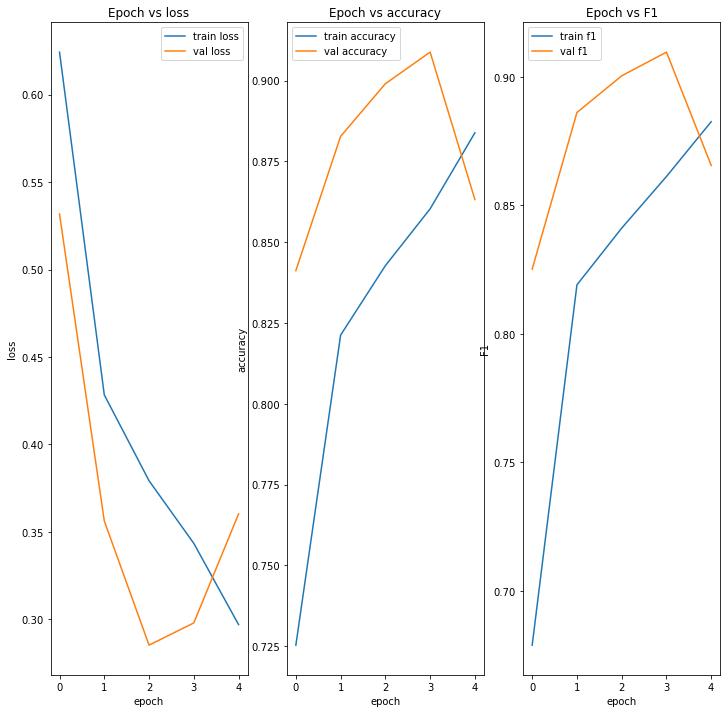

In [16]:
# evaluate the training
plot_results(VGG_model_fit)

#### 4.2. Transfer learning with ResNet
- Optimizer = 'adam'
- Loss = 'categorical_crossentropy'
- Metrics = 'accuracy', 'f1'

F1 score evaluated due to the imbalance of dataset. There are much fewer Covid_19 positive x-rays than normal than pneumonia, which could skew the predictions. F1 score balances the precision and recall for a better evaluation metric.

Last layer of resnet removed and the training image set fed in for transfer learning.

In [32]:
# resnet
transfer_resnet_model = ResNet50(weights='imagenet', 
                                include_top=False)
global_avg_pooling = GlobalAveragePooling2D()(transfer_resnet_model.output)
output = Dense(3, activation='softmax')(global_avg_pooling)
resnet_model = Model(inputs=transfer_resnet_model.input, 
                     outputs=output)
optimizer = optimizers.Adam(learning_rate=1e-5)

resnet_model.compile(loss='categorical_crossentropy', 
                     optimizer=optimizer, 
                     metrics=['accuracy', f1_metric])

In [33]:
# train the model
resnet_model_fit = resnet_model.fit(train_dataset, 
                                    epochs=10, 
                                    validation_data=test_dataset, 
                                    verbose=1)

Epoch 1/5
77/77 [==============================] - 367s 5s/step - loss: 0.2804 - accuracy: 0.8971 - f1_metric: 0.8965 - val_loss: 246.4524 - val_accuracy: 0.6946 - val_f1_metric: 0.700
Epoch 2/5
77/77 [==============================] - 365s 5s/step - loss: 0.1991 - accuracy: 0.9348 - f1_metric: 0.9339 - val_loss: 4.2377 - val_accuracy: 0.2630 - val_f1_metric: 0.265
Epoch 3/5
77/77 [==============================] - 365s 5s/step - loss: 0.1793 - accuracy: 0.9325 - f1_metric: 0.9336 - val_loss: 1.0583 - val_accuracy: 0.6946 - val_f1_metric: 0.693
Epoch 4/5
77/77 [==============================] - 360s 5s/step - loss: 0.1524 - accuracy: 0.9444 - f1_metric: 0.9439 - val_loss: 1.5504 - val_accuracy: 0.6946 - val_f1_metric: 0.693
Epoch 5/5
77/77 [==============================] - 371s 5s/step - loss: 0.1270 - accuracy: 0.9528 - f1_metric: 0.9530 - val_loss: 2.1053 - val_accuracy: 0.0423 - val_f1_metric: 0.047


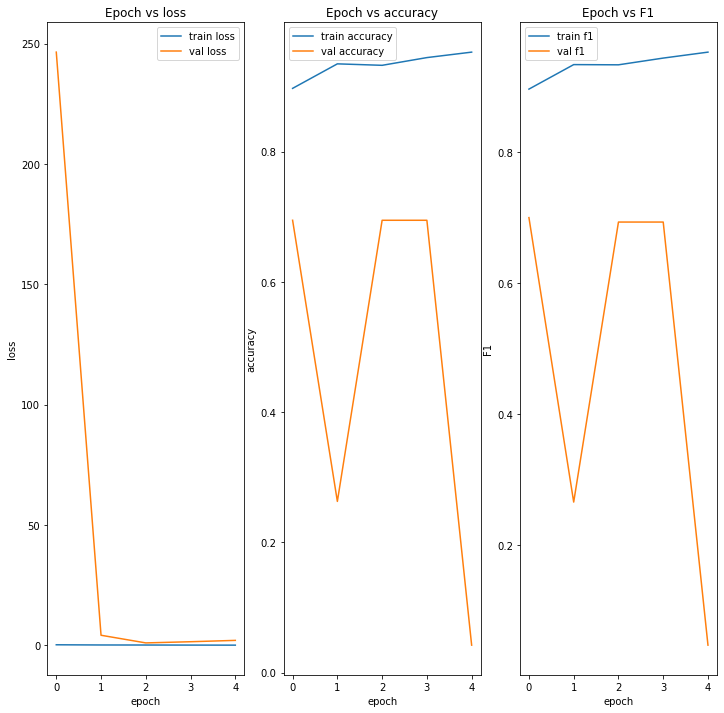

In [34]:
# evaluate the training
plot_results(resnet_model_fit)

#### 4.3. Hyperparameter Tune Transfer learning with ResNet
- Optimizer = 'adam'
- Loss = 'categorical_crossentropy'
- Metrics = 'accuracy', 'f1'
- Dropout = 0.5

Dropouts added to reduce overfitting.

F1 score evaluated due to the imbalance of dataset. There are much fewer Covid_19 positive x-rays than normal than pneumonia, which could skew the predictions. F1 score balances the precision and recall for a better evaluation metric.

Last layer of resnet removed and the training image set fed in for transfer learning.

Callback added for earlystopping when minimum val_loss is reached and best model based on val_loss is saved.

In [35]:
# resnet
transfer_resnet_model = ResNet50(weights='imagenet', 
                                 include_top=False)
global_avg_pooling = GlobalAveragePooling2D()(transfer_resnet_model.output)
dropout = Dropout(rate=0.5)(global_avg_pooling)
output = Dense(3, activation='softmax')(dropout)
tune_resnet_model = Model(inputs=transfer_resnet_model.input, 
                     outputs=output)
optimizer = optimizers.Adam(learning_rate=1e-5)

tune_resnet_model.compile(loss='categorical_crossentropy', 
                     optimizer=optimizer, 
                     metrics=['accuracy', f1_metric])

In [36]:
callback = EarlyStopping(monitor='val_loss', 
                         mode='min', 
                         patience=2)

In [37]:
# train the model
tune_resnet_model_fit = tune_resnet_model.fit(train_dataset, 
                                              epochs=10, 
                                              validation_data=test_dataset,
                                              callbacks=[callback],
                                              verbose=1)

Epoch 1/5
77/77 [==============================] - 374s 5s/step - loss: 0.3161 - accuracy: 0.8896 - f1_metric: 0.8879 - val_loss: 11.9685 - val_accuracy: 0.6946 - val_f1_metric: 0.69
Epoch 2/5
77/77 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9284 - f1_metric: 0.92919

In [ ]:
# evaluate the training
plot_results(tune_resnet_model_fit)

### <ins>5. Recommended Model</ins>

Highest F1 scores are from the tuned transfer learning reset model. Since the dataset is imbalanced with a lot more pneumonia than normal than Covid-19 images, F1 is a better metric for performance evaluation.


### <ins>6. Key Findings</ins>

The dataset available is imbalanced, accuracy alone would provide a skewed interpretation. So evaluations were made on the F1 metric that balances precision and recall.

The loss vs epoch, accuracy vs epoch and f1 vs epoch plots for both training and validation dataset are clearly in the early states of computation given the low number of epoch assigned, so the actual minimum loss/val_loss may result in different F1 scores for the 3 models.

Simpler VGG16 though performed well with higher F1 scores and may still be applicable if small model size is a criteria especially for local inferences in mobile apps like smart phones, tablets where internet availability is poor in remote areas but diagnosis is needed.


### <ins>7. Next Steps</ins>
- The number of epochs were intentionally set to low values due to the length computation time, even with GPU. Given more resources, namely time and better GPU, higher epochs can be used to further improve on the F1 performance metrics and actually reach minimum loss.
- Dynamically vary the learning rate to get reduced when val_loss does not reduce after a number of iterations.
- More Covid-19 images can be added to give a more balanced dataset. More augmentations to the data can be introduced with more complex image manipulations like adding noise and adjusting contrast. 
- Other more advance deep learning models, like Inception and Xception, can explored with transfer learning to reduce training time, especially with more data and augmentations.